In [38]:
import pandas as pd
import numpy as np
from copy import deepcopy

import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns
import scienceplots
plt.style.use(['science', 'no-latex'])

import os
import sys
sys.path.append(os.path.abspath('.'))
from src.plots import set_size

labelmap = {
    "mlp_onehot": "MLP (One-hot)",
    "cnn": "1D-CNN + MLP",
    # "mean_transformer": "Transformer (Mean Pooling)",
}

metrics = ["f1", "acc", "tpr", "misclassified_malicious", "misclassified_benign"]

# LOGS_DIR = "logs_adversarial_poisoning_pollution_WEIRD"
LOGS_DIR = "logs_adversarial_poisoning_pollution"
LIM = 50000
SUBDIRS_SAME_LIM = [os.path.join(LOGS_DIR, x) for x in os.listdir(LOGS_DIR) if str(LIM) in x]

In [39]:
def read_scores_from_dir(directory, pattern):
    score_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith("poisoned_scores_")]

    scores_dict = {}
    
    for score_file in score_files:
        if pattern not in score_file:
            continue
        poison_ratio = float(score_file.split("_")[-1].replace(".json", ""))
        with open(score_file) as f:
            scores = json.load(f)
        # loop over values in scores and if nan then replace with 0
        for metric, value in scores.items():
            if np.isnan(value):
                scores[metric] = 0
        scores_dict[poison_ratio] = scores
    
    return scores_dict


def parse_scores(directories, pattern, metric="f1"):
    score_list = [read_scores_from_dir(x, pattern) for x in directories]
    metric_values = {} # key: poison ratio, value: list of metric values
    for scores in score_list:
        for poison_ratio, score in scores.items():
            if poison_ratio not in metric_values:
                metric_values[poison_ratio] = []
            metric_values[poison_ratio].append(score[metric])

    df = pd.DataFrame()
    for poison_ratio, values in metric_values.items():
        df.loc[poison_ratio, "mean"] = np.mean(values)
        df.loc[poison_ratio, "std"] = np.std(values)

    df = df.sort_index()
    df.index.name = "Poison Ratio"
    return df


def plot_scatter_lines(df, metric="f1", model_name="", xlim=[0.0007, 1]):
    scores = deepcopy(df)
    fig, ax = plt.subplots(1, 1, figsize=set_size())
    
    # remove 0.0 poison ratio
    baseline = scores.loc[0.0, "mean"]
    scores = scores.drop(0.0)

    # mean as scatter plot, std as errbars
    ax.scatter(scores.index, scores["mean"], color="black", marker="x", label="Mean")
    ax.errorbar(scores.index, scores["mean"], yerr=scores["std"], color="black", ls="none", label="Std", capsize=3)
    # add dashed line between scatter points
    ax.plot(scores.index, scores["mean"], color="black", ls="--")

    # plot red dashed line for baseline
    ax.axhline(baseline, color="red", ls="--", label="Baseline")

    ax.set_xlabel("Poison Ratio")
    ax.set_ylabel(metric.replace("_", " ").capitalize())
    ax.set_title(model_name)
    ax.set_xscale("log")
    vals = ax.get_xticks()
    # convert xlabels to percentages, put .1% for 0.001, others .0%
    ax.xaxis.set_major_locator(mticker.FixedLocator(vals))
    ax.set_xticklabels(['{:.1%}'.format(x) if x == 0.001 else '{:.0%}'.format(x) for x in vals])
    
    if xlim is not None:
        ax.set_xlim(xlim)
    return fig, ax

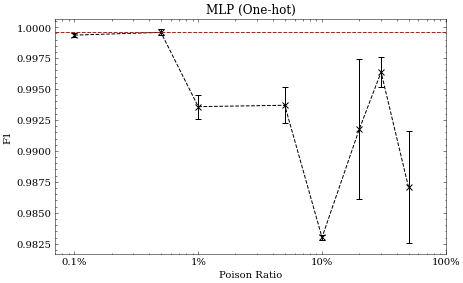

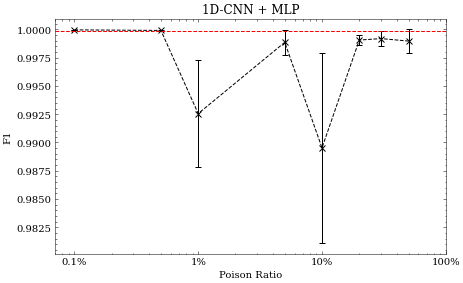

In [40]:
for pattern in labelmap.keys():
    metric = "f1"
    df = parse_scores(SUBDIRS_SAME_LIM, pattern, metric=metric)
    plot_scatter_lines(df, model_name=labelmap[pattern], metric=metric)

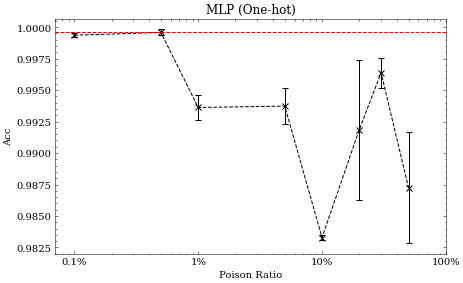

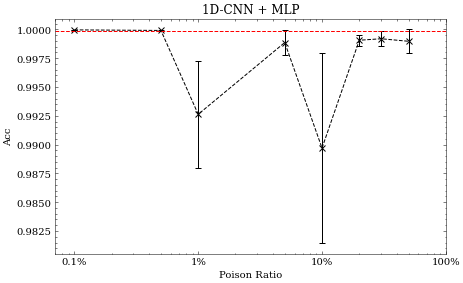

In [41]:
for pattern in labelmap.keys():
    metric = metrics[1]
    df = parse_scores(SUBDIRS_SAME_LIM, pattern, metric=metric)
    plot_scatter_lines(df, model_name=labelmap[pattern], metric=metric)

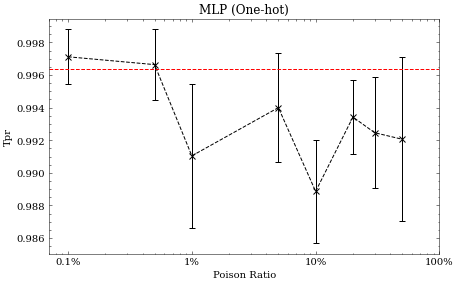

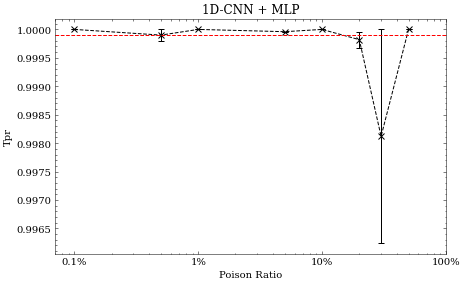

In [42]:
for pattern in labelmap.keys():
    metric = metrics[2]
    df = parse_scores(SUBDIRS_SAME_LIM, pattern, metric=metric)
    plot_scatter_lines(df, model_name=labelmap[pattern], metric=metric)

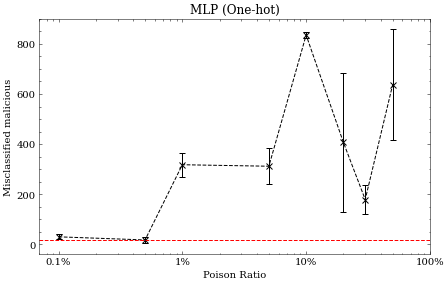

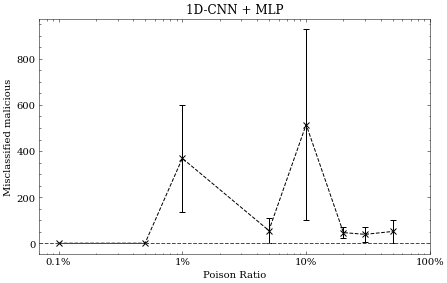

In [43]:
for pattern in labelmap.keys():
    metric = metrics[3]
    df = parse_scores(SUBDIRS_SAME_LIM, pattern, metric=metric)
    plot_scatter_lines(df, model_name=labelmap[pattern], metric=metric)

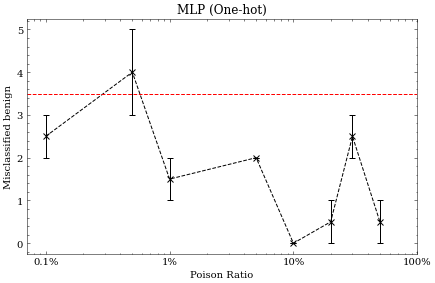

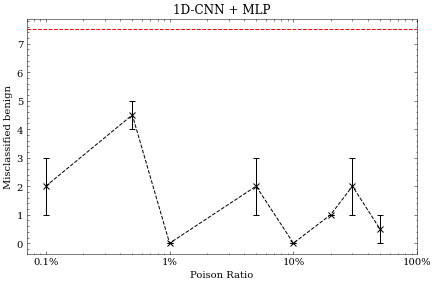

In [44]:
for pattern in labelmap.keys():
    metric = metrics[4]
    df = parse_scores(SUBDIRS_SAME_LIM, pattern, metric=metric)
    plot_scatter_lines(df, model_name=labelmap[pattern], metric=metric)